### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read GoF files to calculate p-value
2. Use GoF to show F-test results

env:bbVV


In [1]:
from typing import List
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import os

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 20})


In [2]:
MAIN_DIR = "../../"

plot_dir = f"{MAIN_DIR}/plots/GoF/25Jan24"
_ = os.system(f"mkdir -p {plot_dir}")

In [3]:
def p_value(data_ts: float, toy_ts: List[float]):
    return np.mean(toy_ts >= data_ts)


def F_statistic(
    ts_low: List[float],
    ts_high: List[float],
    ord_low: int,
    ord_high: int,
    num_bins: int = 10 * 2,
    dim: int = 0, #not sure what this option is for
):
    numerator = (ts_low - ts_high) / (ord_high - ord_low)
    denominator = ts_high / (num_bins - (ord_high + dim))

    return numerator / denominator

### HWW

In [15]:
local_cards_dir = "/home/pku/zhaoyz/Higgs/boostedHWW/combine/scripts/f_test/cards/"
test_orders = [4]
test_statistics = {}

for o1 in test_orders:
    tdict = {"toys": {}, "data": {}, "ftoys": {}, "fdata": {}}
    tlabel = f"{o1}"

    for nTF in [o1, o1 + 1]:
        # for nTF1, nTF2 in [(o1, o2)]:
        tflabel = f"{nTF}"

        # test statistics for toys generated by (o1, o2) order model
        file = uproot.concatenate(
            f"{local_cards_dir}/nTF_{nTF}/higgsCombineToys{tlabel}.GoodnessOfFit.mH125.42.root"
        )
        tdict["toys"][tflabel] = np.array(file["limit"])

        # data test statistic
        file = uproot.concatenate(
            f"{local_cards_dir}/nTF_{nTF}/higgsCombineData.GoodnessOfFit.mH125.root"
        )
        tdict["data"][tflabel] = file["limit"][0]

        if not nTF == o1: #with higher order
            tdict["ftoys"][tflabel] = F_statistic(
                tdict["toys"][tlabel], tdict["toys"][tflabel], o1, nTF
            )
            tdict["fdata"][tflabel] = F_statistic(
                tdict["data"][tlabel], tdict["data"][tflabel], o1, nTF
            )

    test_statistics[tlabel] = tdict

In [12]:
a = uproot.concatenate(f"{local_cards_dir}/nTF_4/higgsCombineData.GoodnessOfFit.mH125.root")
a["limit"][0]


47.43934714794159

In [13]:
tdict["toys"]["4"]

array([48.57386601, 34.94822776, 48.85103035, 41.36739635, 41.9572283 ,
       32.77834868, 41.54767585, 27.015365  , 44.92550099, 38.86497307,
       51.9630816 , 60.7175895 , 38.24118805, 22.25478244, 42.89746046,
       35.15694153, 36.76802313, 30.25727606, 39.36215436, 39.35316443,
       29.21525586, 22.68361974, 31.27048206, 27.49850678, 43.74101102,
       69.94755435, 30.29506254, 44.69146836, 36.80883479, 38.15098703,
       33.34472752, 50.37869656, 27.52537382, 47.16707468, 54.54649568,
       35.13657427, 54.40876067, 37.17734277, 36.36772633, 53.90301859,
       50.68756711, 43.42742419, 38.43101275, 35.27497828, 28.73355854,
       34.66874063, 42.00191474, 38.83668494, 31.52981329, 37.78117931,
       40.20870256, 39.25652957, 26.03613603, 41.78292835, 35.35316753,
       46.88937593, 30.95394278, 31.63285887, 32.83180988, 38.36678267,
       29.83053684, 39.95564079, 30.90671206, 26.91692734, 31.63029134,
       33.61489189, 27.42048264, 37.79824233, 46.25490558, 44.01

In [7]:
tdict["data"]["3"]

107.03990864753723

In [16]:
from scipy import stats


def plot_tests(
    data_ts: float,
    toy_ts: np.ndarray,
    name: str,
    title: str = None,
    bins: int = 15,
    fit: str = None,
    fdof2: int = None,
    order_value: str = None
):
    # plot_max = max(np.max(toy_ts), data_ts) #not enough
    plot_max = 100
    # plot_max = max(np.max(toy_ts), data_ts) if fit != "chi2" else 200
    # plot_min = min(np.min(toy_ts), data_ts, 0)
    plot_min = 0
    pval = p_value(data_ts, toy_ts)

    plt.figure(figsize=(12, 8))
    h = plt.hist(
        toy_ts,
        np.linspace(plot_min, plot_max, bins + 1),
        color="#8C8C8C",
        histtype="step",
        label=f"{len(toy_ts)} Toys",
    )
    plt.axvline(data_ts, color="#FF502E", linestyle=":", label=rf"Data ($p$-value = {pval:.2f})")

    if fit is not None:
        x = np.linspace(plot_min + 0.01, plot_max, 100)

        if fit == "chi2":
            res = stats.fit(stats.chi2, toy_ts, [(0, 200)])
            pdf = stats.chi2.pdf(x, res.params.df)
            label = rf"$\chi^2_{{DoF = {res.params.df:.2f}}}$ Fit"
        elif fit == "f":
            pdf = stats.f.pdf(x, 1, fdof2)
            label = rf"$F-dist_{{DoF = (1, {fdof2})}}$"
        else:
            raise ValueError("Invalid fit")

        plt.plot(
            x,
            pdf * (np.max(h[0]) / np.max(pdf)),
            color="#1f78b4",
            linestyle="--",
            # alpha=0.6,
            label=label,
        )

    hep.cms.label(
        "Work in Progress",
        data=True,
        lumi=138,
        year=None,
    )

    _ = plt.legend()
    plt.title(title)
    plt.ylabel("Number of Toys")
    plt.xlabel(f"Test Statistics") #need to be modified for F test value

    plt.savefig(f"{plot_dir}/{name}.pdf", bbox_inches="tight")

### plot GoF and F-test results

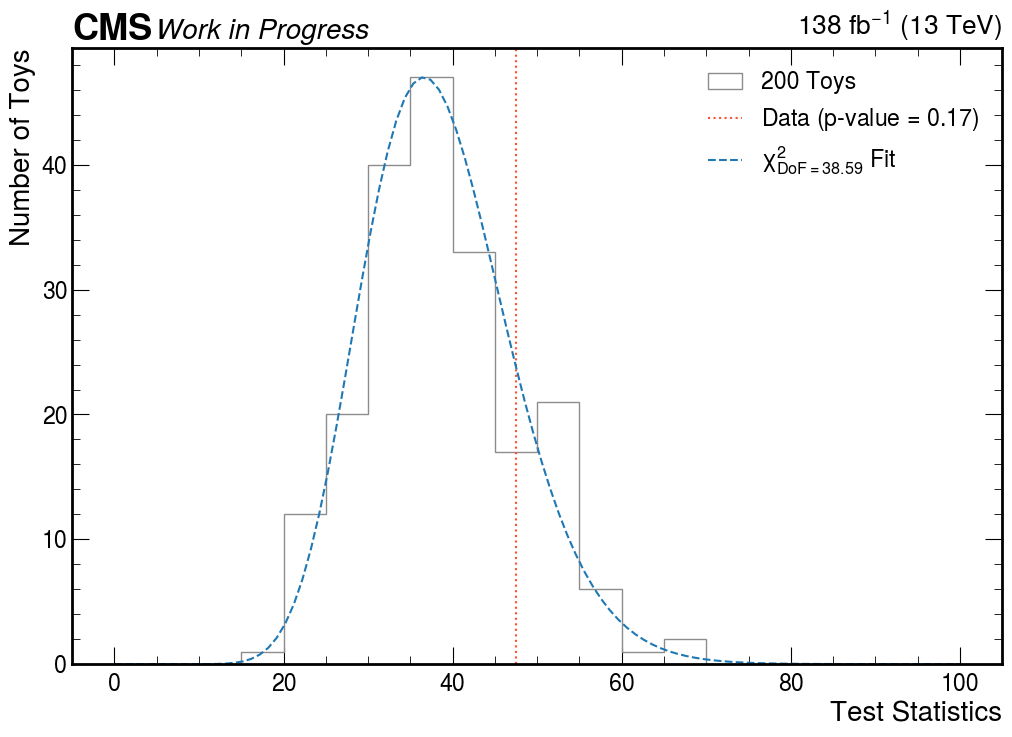

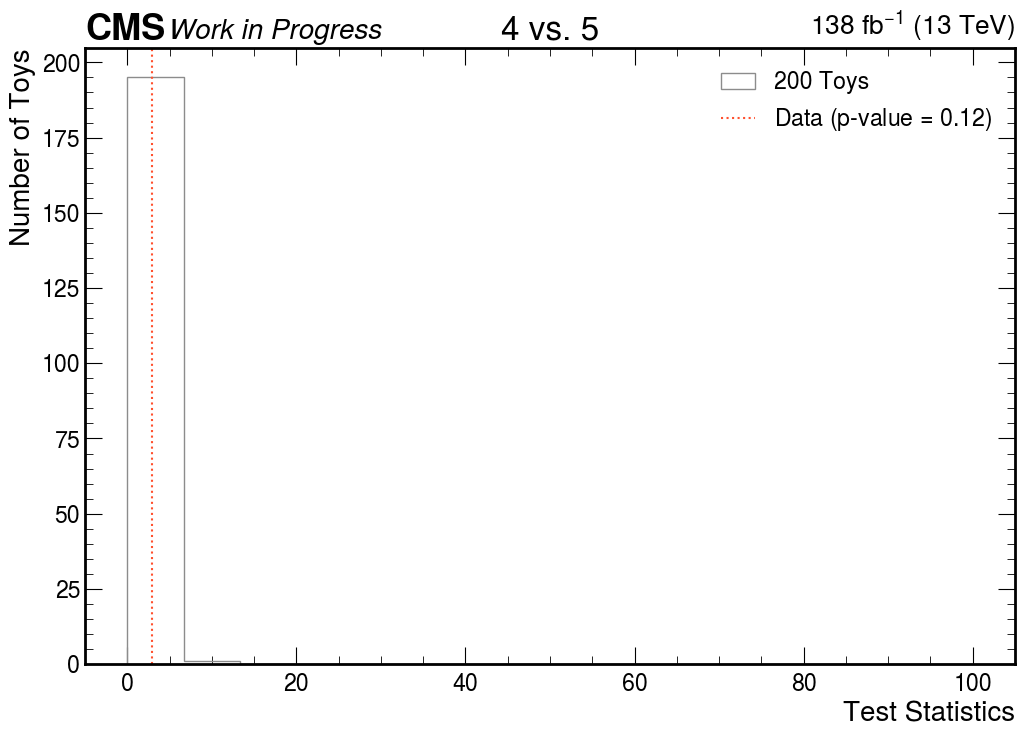

In [17]:
o1 = 4 # order being tested
tlabel = f"{o1}"

data_ts, toy_ts = test_statistics[tlabel]["data"][tlabel], test_statistics[tlabel]["toys"][tlabel]
plot_tests(data_ts, toy_ts, "gof" + tlabel, fit="chi2", bins=20, order_value = tlabel)

ord1 = 5 # next higher order
tflabel = f"{ord1}"
data_ts, toy_ts = pval = (
    test_statistics[tlabel]["fdata"][tflabel],
    test_statistics[tlabel]["ftoys"][tflabel],
)
plot_tests(data_ts, toy_ts, f"f{tlabel}_{tflabel}", title=f"{o1} vs. {ord1}")

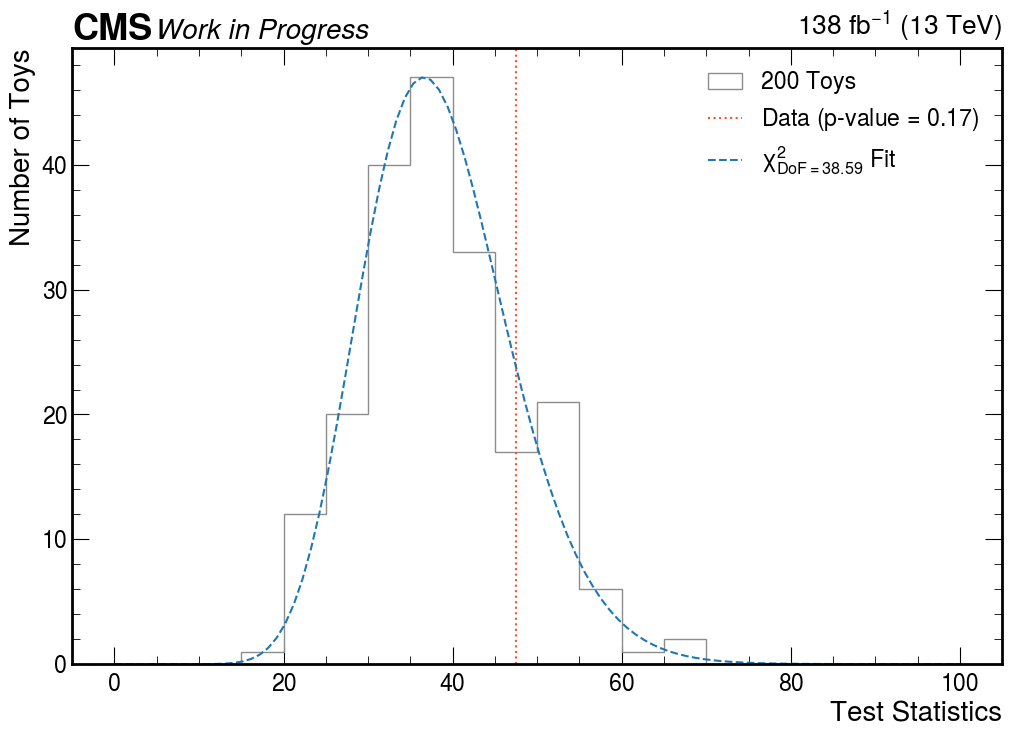

In [18]:
data_ts, toy_ts = tdict["data"][tlabel], tdict["toys"][tlabel]
plot_tests(data_ts, toy_ts, "gof" + tlabel, fit="chi2", bins=20)